# Voice-Sleep Analysis

This notebook performs exploratory data analysis (EDA) and baseline evaluation
based on the extracted audio features stored in: data/processed/features.csv

Before running this notebook, make sure you have generated the features using: python src/extract_features.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
%matplotlib inline

### 1. Load Data

We begin by loading the processed dataset, which contains MFCC-based acoustic features,
pitch statistics, energy measures, and the corresponding sleep-quality label
assigned to each morning voice recording.

In [9]:
features_path = Path('../data/processed/features.csv')
assert features_path.exists(), 'Run src/extract_features.py first'
df = pd.read_csv(features_path)
df.head(20)

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,pitch_mean,energy,label,file
0,-412.81723,71.279750,16.449442,28.138237,7.737292,-0.058680,-0.228144,7.477249,2.445854,-3.116749,3.438591,0.808018,-4.477230,1597.5449,0.014701,1,sleep1_1.wav
1,-280.32077,89.047400,-23.488703,12.836379,3.714630,0.804114,5.718291,-5.604379,-1.065007,3.448220,-0.381789,2.293405,-4.883587,1760.1904,0.038619,1,sleep1_10.wav
2,-299.34274,78.410360,-15.990219,24.794230,4.550678,5.567184,7.183277,-0.186297,-0.500812,6.385096,-2.169277,3.654286,-4.012601,1526.4985,0.026169,1,sleep1_11.wav
3,-280.32077,89.047400,-23.488703,12.836379,3.714630,0.804114,5.718291,-5.604379,-1.065007,3.448220,-0.381789,2.293405,-4.883587,1760.1904,0.038619,1,sleep1_12.wav
4,-273.62656,104.458350,-16.311775,20.928347,12.334682,0.938202,4.695052,2.932898,-10.773287,5.483014,0.617050,1.923930,-2.801184,1048.0680,0.034572,1,sleep1_13.wav
5,-244.30121,82.449196,-14.443731,26.816069,16.692606,2.248120,-1.548456,4.555402,-5.814349,3.186824,-3.353936,4.014854,0.105028,1431.8926,0.040185,1,sleep1_14.wav
6,-274.07336,70.488440,-17.976076,13.186944,13.240552,-3.991271,-5.072026,2.992852,-4.260805,2.766694,-6.227744,2.337672,-0.107684,1822.6202,0.029957,1,sleep1_15.wav
7,-381.23730,48.182247,38.658690,18.110998,18.059595,13.282350,9.848008,8.593284,1.442166,3.521658,3.516859,5.515779,-5.530775,1735.7175,0.026827,1,sleep1_2.wav
8,-244.79239,82.230640,-23.941689,40.109030,-4.863439,23.207932,-5.670155,2.243334,-10.609835,1.202019,-2.719122,-6.138860,5.005982,1711.4883,0.039401,1,sleep1_3.wav
9,-258.60583,77.247540,-25.476984,38.838245,0.667747,20.923980,-7.530318,0.636184,-8.511872,1.828729,-7.419824,-3.221281,3.198441,1817.1575,0.031449,1,sleep1_4.wav


### 2. Dataset Overview

In this section, we inspect:

the number of samples collected

the distribution of sleep scores (1–5)

summary statistics of MFCC, pitch, and energy features

basic correlations between features and labels

This helps us understand dataset balance and whether certain features
may carry useful information about sleep quality.

In [10]:
print(f'Shape: {df.shape}')
display(df.describe().T)
label_counts = df['label'].value_counts().sort_index()
print('Label counts:\n', label_counts)

Shape: (72, 17)


,count,mean,std,min,25%,50%,75%,max
mfcc_0,72.0,-374.777209,99.877493,-661.196530,-442.165257,-381.322280,-282.227865,-209.306080
mfcc_1,72.0,83.082464,22.515609,28.619703,69.533821,89.528728,98.122841,137.585130
mfcc_2,72.0,4.501416,19.726845,-31.747700,-14.928070,4.783606,20.205596,41.601006
mfcc_3,72.0,20.828763,12.331880,-13.893601,15.370702,22.750569,28.376037,44.032738
mfcc_4,72.0,2.198440,10.001513,-20.637865,-4.680335,3.377718,9.344214,19.026814
mfcc_5,72.0,6.237105,9.360029,-14.099175,0.659119,3.770986,12.792869,27.443945
mfcc_6,72.0,-5.530399,8.743684,-31.993452,-10.310184,-3.704118,0.269261,9.848008
mfcc_7,72.0,0.890780,5.211143,-13.742249,-2.016206,0.691506,3.340425,17.715986
mfcc_8,72.0,-3.633707,5.352862,-15.364110,-7.457673,-4.172579,1.359475,8.009908
mfcc_9,72.0,1.807124,5.928315,-23.493254,-0.978511,2.556416,4.953177,15.485115


Label counts:
 label
1    15
2    13
3    14
4    16
5    14
Name: count, dtype: int64


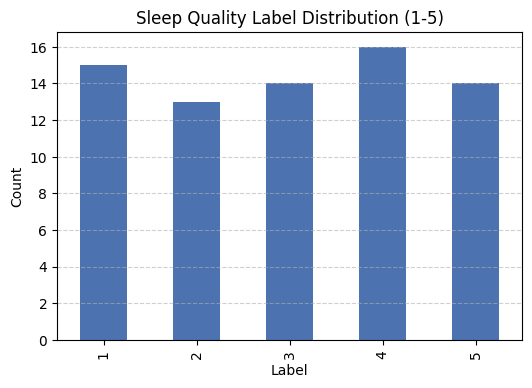

In [11]:
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color='#4C72B0')
plt.title('Sleep Quality Label Distribution (1-5)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### 3. Baseline Modeling Setup

We evaluate two predictive tasks:

Regression

Predicting the continuous sleep score (1–5).
Evaluation metric: RMSE (Root Mean Squared Error).

Binary Classification

We convert sleep score into two classes:

0 → Low/poor sleep (score < 3)

1 → Good sleep (score ≥ 3)

Evaluation metric: Accuracy.

These baselines allow us to measure how well simple models perform
on low-dimensional acoustic features.

In [12]:
X = df.drop(columns=['label', 'file'])
y_reg = df['label']
y_clf = (df['label'] >= 3).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42, stratify=y_clf)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

reg = LinearRegression().fit(X_train_sc, y_train)
rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test_sc)))
print(f'Linear Regression RMSE: {rmse:.3f}')

X_train, X_test, y_train, y_test = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
clf = LogisticRegression(max_iter=200).fit(X_train_sc, y_train)
acc = accuracy_score(y_test, clf.predict(X_test_sc))
print(f'Logistic Regression Accuracy: {acc:.3f}')

Linear Regression RMSE: 1.494
Logistic Regression Accuracy: 0.667


## K-Fold evaluation (aligns with src/evaluate_with_plots.py)

In [13]:
def evaluate_regression(models, X, y, k=5):
    results = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for name, model in models.items():
        scores = []
        for tr, te in kf.split(X):
            X_tr, X_te = X.iloc[tr], X.iloc[te]
            y_tr, y_te = y.iloc[tr], y.iloc[te]
            sc = StandardScaler()
            X_tr_sc = sc.fit_transform(X_tr)
            X_te_sc = sc.transform(X_te)
            model.fit(X_tr_sc, y_tr)
            pred = model.predict(X_te_sc)
            scores.append(np.sqrt(mean_squared_error(y_te, pred)))
        results.append({'Model': name, 'RMSE_Mean': np.mean(scores), 'RMSE_Std': np.std(scores)})
    return pd.DataFrame(results)

def evaluate_classification(models, X, y, k=5):
    results = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for name, model in models.items():
        scores = []
        for tr, te in kf.split(X):
            X_tr, X_te = X.iloc[tr], X.iloc[te]
            y_tr, y_te = y.iloc[tr], y.iloc[te]
            sc = StandardScaler()
            X_tr_sc = sc.fit_transform(X_tr)
            X_te_sc = sc.transform(X_te)
            model.fit(X_tr_sc, y_tr)
            pred = model.predict(X_te_sc)
            scores.append(accuracy_score(y_te, pred))
        results.append({'Model': name, 'Acc_Mean': np.mean(scores), 'Acc_Std': np.std(scores)})
    return pd.DataFrame(results)

models_reg = {
    'LinearRegression': LinearRegression(),
    'kNN_Regressor': KNeighborsRegressor(n_neighbors=5)
}
models_clf = {
    'LogisticRegression': LogisticRegression(max_iter=200),
    'kNN_Classifier': KNeighborsClassifier(n_neighbors=5)
}

reg_df = evaluate_regression(models_reg, X, y_reg)
clf_df = evaluate_classification(models_clf, X, y_clf)
display(reg_df)
display(clf_df)

,Model,RMSE_Mean,RMSE_Std
0,LinearRegression,1.452363,0.148792
1,kNN_Regressor,1.312095,0.114341


,Model,Acc_Mean,Acc_Std
0,LogisticRegression,0.695238,0.066052
1,kNN_Classifier,0.638095,0.057143


### 5. Plotting Cross-Validation Results

We visualize the aggregated CV performance for:

Linear Regression vs. kNN Regression (RMSE comparison)

Logistic Regression vs. kNN Classifier (Accuracy comparison)

Error bars represent the standard deviation across folds,
illustrating stability and variance in model performance.

These plots are also saved automatically when running:

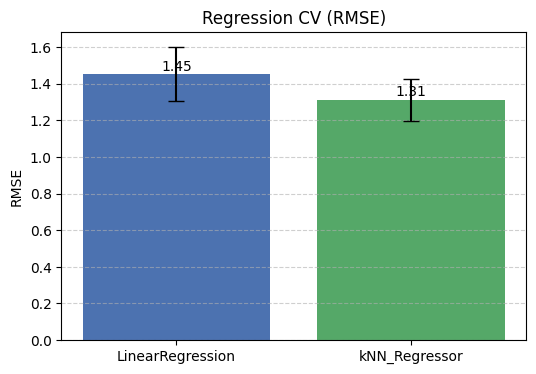

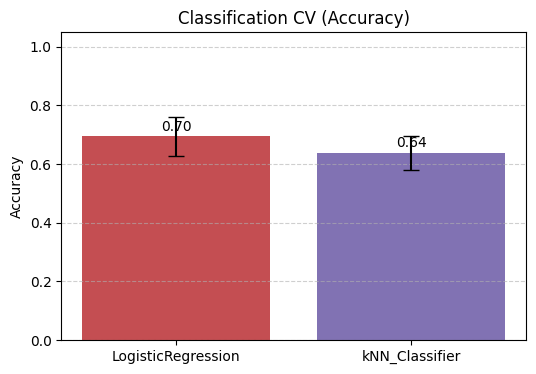

In [14]:
plt.figure(figsize=(6,4))
bars = plt.bar(reg_df['Model'], reg_df['RMSE_Mean'], yerr=reg_df['RMSE_Std'], capsize=6, color=['#4C72B0', '#55A868'])
plt.ylabel('RMSE')
plt.title('Regression CV (RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.02, f'{b.get_height():.2f}', ha='center')
plt.show()

plt.figure(figsize=(6,4))
bars = plt.bar(clf_df['Model'], clf_df['Acc_Mean'], yerr=clf_df['Acc_Std'], capsize=6, color=['#C44E52', '#8172B3'])
plt.ylabel('Accuracy')
plt.title('Classification CV (Accuracy)')
plt.ylim(0,1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.02, f'{b.get_height():.2f}', ha='center')
plt.show()


### 6. Optional: Load Saved Evaluation Results
If cross-validation has already been computed and exported
(e.g., using evaluate.py), this section allows loading:

data/processed/eval_results.csv


and analyzing the results without re-running the models.

In [15]:
eval_path = Path('../data/processed/eval_results.csv')
if eval_path.exists():
    display(pd.read_csv(eval_path))
else:
    print('Run src/evaluate_with_plots.py to generate eval_results.csv')

,Model,Metric,Mean,Std
0,LinearRegression,RMSE,1.452363,0.148792
1,kNN_Regressor,RMSE,1.312095,0.114341
2,LogisticRegression,Accuracy,0.695238,0.066052
3,kNN_Classifier,Accuracy,0.638095,0.057143


## 6. Inference Demo (Using Trained Models)

Here we demonstrate how to run sleep score prediction on a new audio sample
using the trained models saved in the `models/` directory.

This uses the same `inference.py` pipeline shown in the README.

In [11]:
import sys
import subprocess

PY = "python"  
INFER = r"D:\CS441_Final_Proejct_Voice_Sleep\inference.py"

# Pick an audio file from data/raw
result = subprocess.run(
    [PY, INFER, "../data/raw/sleep1_1.wav"], # change to any of your files
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

print(result.stdout)
print(result.stderr)



Predicted sleep score (regression): 1.840
Predicted sleep quality (0=bad, 1=good): 0


